In [65]:
# import libraries and dependencies
import pandas as pd
import panel as pn
import numpy as np
import hvplot.pandas
import yfinance as yf
import plotly.graph_objects as go
import plotly.express as px
from pandas_datareader import data as pdr
import seaborn as sns
import matplotlib.pyplot as plt

# --STOCK DATA-- 
## Get SPY Data

In [2]:
# set ticker
ticker = "SPY"

# set timeframe for data
start = '2020-01-01'
end = '2021-01-01'

# pull historical stock data from 1/10/2005 to 3/8/2021
yf.pdr_override()
df_spy_historical_stock_data = pdr.get_data_yahoo(ticker, start=start, end=end)

# drop Dividends and Stock Split columns
df_spy_historical_stock_data = df_spy_historical_stock_data.drop(columns=['Adj Close']).reset_index()
df_spy_historical_stock_data.head()

[*********************100%***********************]  1 of 1 completed


Date        Open        High         Low       Close    Volume
0 2020-01-02  323.540009  324.890015  322.529999  324.869995  59151200
1 2020-01-03  321.160004  323.640015  321.100006  322.410004  77709700
2 2020-01-06  320.489990  323.730011  320.359985  323.640015  55653900
3 2020-01-07  323.019989  323.540009  322.239990  322.730011  40496400
4 2020-01-08  322.940002  325.779999  322.670013  324.450012  68296000

## Candlestick Chart - SPY

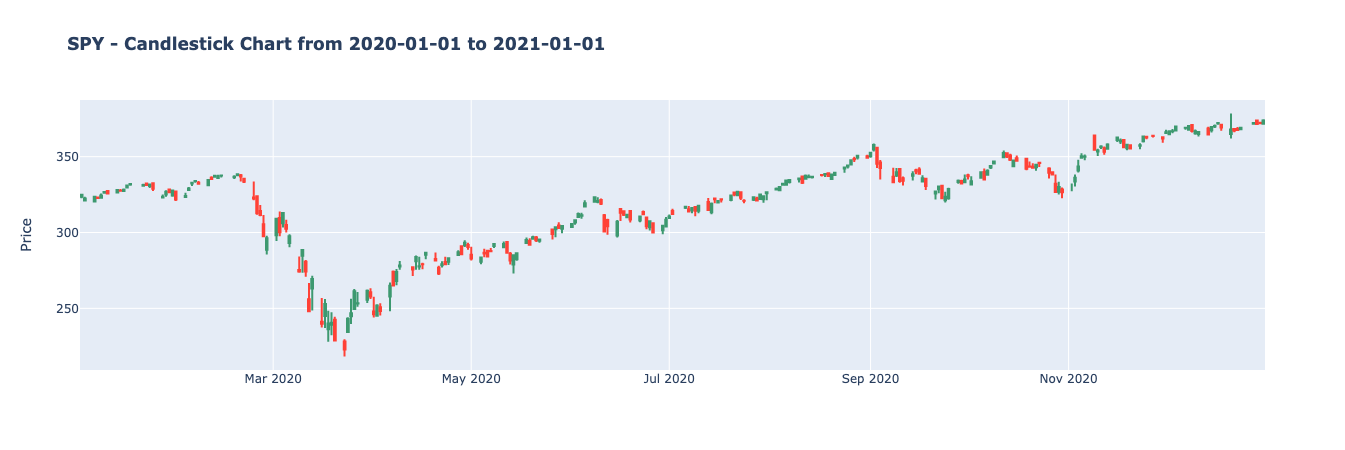

In [3]:
# plot SPY candlestick chart
spy_candlestick_chart = go.Figure(data=[go.Candlestick(x=df_spy_historical_stock_data['Date'],
                open=df_spy_historical_stock_data['Open'],
                high=df_spy_historical_stock_data['High'],
                low=df_spy_historical_stock_data['Low'],
                close=df_spy_historical_stock_data['Close'])])
spy_candlestick_chart.update_layout(
    title=f'<b>SPY - Candlestick Chart from {start} to {end}</b>',
    yaxis_title='Price',
    xaxis_rangeslider_visible=False)
spy_candlestick_chart.show()

## Closing Prices Line Chart - SPY

In [4]:
# slice historical stock data for closing prices
spy_close_prices = df_spy_historical_stock_data[['Date','Close']]

#rename close column to spy_close and set Date as index
spy_close_prices.rename(columns = {'Close':'spy_close'}, inplace = True)
spy_close_prices.set_index(keys = "Date" , inplace = True)
spy_close_prices.head()

/opt/anaconda3/envs/pyvizenv/lib/python3.7/site-packages/pandas/core/frame.py:4025: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



spy_close
Date                  
2020-01-02  324.869995
2020-01-03  322.410004
2020-01-06  323.640015
2020-01-07  322.730011
2020-01-08  324.450012

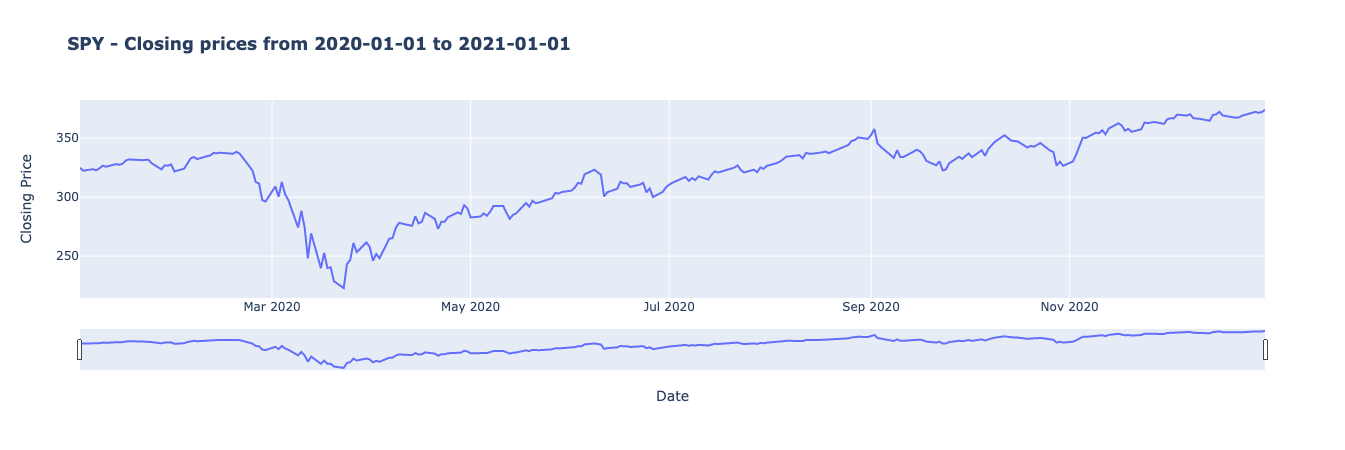

In [5]:
chart_spy_close_prices = px.line(spy_close_prices, y="spy_close", title=f'<b>SPY - Closing prices from {start} to {end}</b>')
chart_spy_close_prices.update_layout(yaxis_title='Closing Price',
                                     xaxis_rangeslider_visible=True)
chart_spy_close_prices.show()

# --OPTIONS DATA--
## Get SPY Options Data

In [8]:
# import historical options data
df_spy_historical_options_data = pd.read_csv('SPY_historical_options_data/SPY_2020.csv')

#remove rows where 'openinterest' equals zero and drop columns
df_spy_historical_options_data = df_spy_historical_options_data[df_spy_historical_options_data.openinterest != 0].reset_index(drop=True)
df_spy_historical_options_data = df_spy_historical_options_data.drop(columns=[' exchange','optionroot','optionext','impliedvol','delta','gamma',
                                                                              'theta','vega','optionalias','IVBid','IVAsk','bid','ask'])
df_spy_historical_options_data.rename(columns = {'expiration':'Date'}, inplace = True)
df_spy_historical_options_data['Date'] = pd.to_datetime(df_spy_historical_options_data['Date'])
# df_spy_historical_options_data['Date'] = df_spy_historical_options_data['Date'] - pd.Timedelta(1, unit='D')
df_spy_historical_options_data.set_index(keys = "Date" , inplace = True)

df_spy_historical_options_data.head()

underlying  underlying_last type   quotedate  strike  last  volume  \
Date                                                                            
2020-01-03        SPY           324.87  put  01/02/2020   260.0  0.00       0   
2020-01-03        SPY           324.87  put  01/02/2020   265.0  0.01       0   
2020-01-03        SPY           324.87  put  01/02/2020   270.0  0.01       0   
2020-01-03        SPY           324.87  put  01/02/2020   272.5  0.01       0   
2020-01-03        SPY           324.87  put  01/02/2020   275.0  0.01       0   

            openinterest  
Date                      
2020-01-03          4239  
2020-01-03         32850  
2020-01-03         47124  
2020-01-03          5649  
2020-01-03          1161

# --MERGE DATA--
## Merge stocks and options data

In [9]:
# merge stock data and options data
df_stocks_and_options = pd.merge(
    spy_close_prices,
    df_spy_historical_options_data,
    how="inner",
    on="Date",
    left_on=None,
    sort=True
)

df_stocks_and_options = df_stocks_and_options.reset_index()
df_stocks_and_options.rename(columns = {"Date":"expiration_date",
                                       "spy_close":"spy_close_exp_date",
                                       "underlying_last":"spy_close_quotedate"}, inplace = True)

df_stocks_and_options = df_stocks_and_options[["underlying",
                                               "quotedate",
                                               "expiration_date",
                                               "strike",
                                               "type",
                                               "last",
                                               "volume",
                                               "openinterest",
                                               "spy_close_quotedate",
                                               "spy_close_exp_date",
                                              ]]

In [10]:
# format data types
df_stocks_and_options['quotedate'] = pd.to_datetime(df_stocks_and_options['quotedate'])
# df_stocks_and_options = df_stocks_and_options.set_index("quotedate")
df_stocks_and_options['strike'] = df_stocks_and_options['strike'].astype(float)
df_stocks_and_options['last'] = df_stocks_and_options['last'].astype(float)
df_stocks_and_options['spy_close_quotedate'] = df_stocks_and_options['spy_close_quotedate'].astype(float)
df_stocks_and_options['spy_close_exp_date'] = df_stocks_and_options['spy_close_exp_date'].astype(float)
df_stocks_and_options.head()

underlying  quotedate expiration_date  strike type  last  volume  \
0        SPY 2020-01-02      2020-01-03   260.0  put  0.00       0   
1        SPY 2020-01-02      2020-01-03   265.0  put  0.01       0   
2        SPY 2020-01-02      2020-01-03   270.0  put  0.01       0   
3        SPY 2020-01-02      2020-01-03   272.5  put  0.01       0   
4        SPY 2020-01-02      2020-01-03   275.0  put  0.01       0   

   openinterest  spy_close_quotedate  spy_close_exp_date  
0          4239               324.87          322.410004  
1         32850               324.87          322.410004  
2         47124               324.87          322.410004  
3          5649               324.87          322.410004  
4          1161               324.87          322.410004

# --ATM OPTIONS--
## Create new column : Days to Expiry

In [11]:
# reset index
#calc and insert column 'days to expiry'
# x[['expiration_date','quotedate']] = x[['expiration_date','quotedate']].apply(pd.to_datetime) #if conversion required
df_stocks_and_options['days_to_expiry'] = (df_stocks_and_options['expiration_date'] - df_stocks_and_options['quotedate']).dt.days
df_stocks_and_options.head()

underlying  quotedate expiration_date  strike type  last  volume  \
0        SPY 2020-01-02      2020-01-03   260.0  put  0.00       0   
1        SPY 2020-01-02      2020-01-03   265.0  put  0.01       0   
2        SPY 2020-01-02      2020-01-03   270.0  put  0.01       0   
3        SPY 2020-01-02      2020-01-03   272.5  put  0.01       0   
4        SPY 2020-01-02      2020-01-03   275.0  put  0.01       0   

   openinterest  spy_close_quotedate  spy_close_exp_date  days_to_expiry  
0          4239               324.87          322.410004               1  
1         32850               324.87          322.410004               1  
2         47124               324.87          322.410004               1  
3          5649               324.87          322.410004               1  
4          1161               324.87          322.410004               1

## Create new dataframe for ATM options

In [12]:
##
df_atm_options = df_stocks_and_options

df_atm_options['strike'] = df_atm_options['strike'].astype(int)
df_atm_options['spy_close_quotedate'] = df_atm_options['spy_close_quotedate'].astype(int)

index_names = df_atm_options[ df_atm_options['strike'] != (df_atm_options['spy_close_quotedate'])].index
df_atm_options = df_atm_options.drop(index_names) 

#sort and reset
df_atm_options = df_atm_options.sort_values(by = ['expiration_date'], ascending=True).reset_index()
df_atm_options.head()

index underlying  quotedate expiration_date  strike  type  last  volume  \
0    137        SPY 2020-01-02      2020-01-03     324  call  1.20   67169   
1    138        SPY 2020-01-02      2020-01-03     324   put  0.28   56412   
2    139        SPY 2020-01-02      2020-01-03     324  call  0.77   24561   
3    140        SPY 2020-01-02      2020-01-03     324   put  0.44   14515   
4    309        SPY 2020-01-03      2020-01-03     322  call  0.67   38277   

   openinterest  spy_close_quotedate  spy_close_exp_date  days_to_expiry  
0         17299                  324          322.410004               1  
1          4491                  324          322.410004               1  
2          8455                  324          322.410004               1  
3           625                  324          322.410004               1  
4         18142                  322          322.410004               0

# --OPTIONS IMPLIED PRICE
## Calculate options implied price

In [14]:
atm_calls = df_atm_options.loc[df_atm_options['type'] == 'call']
atm_calls['Options_Implied_Price'] = atm_calls['strike'] + atm_calls['last']

atm_puts = df_atm_options.loc[df_atm_options['type'] == 'put']
atm_puts['Options_Implied_Price'] = atm_puts['strike'] - atm_puts['last']

z = pd.concat([atm_calls,atm_puts],axis=0, sort=True).dropna().reset_index(drop=True)

z.head()

/opt/anaconda3/envs/pyvizenv/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/opt/anaconda3/envs/pyvizenv/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



Options_Implied_Price  days_to_expiry expiration_date  index  last  \
0                 325.20               1      2020-01-03    137  1.20   
1                 324.77               1      2020-01-03    139  0.77   
2                 322.67               0      2020-01-03    309  0.67   
3                 322.25               0      2020-01-03    311  0.25   
4                 323.80               0      2020-01-06    601  0.80   

   openinterest  quotedate  spy_close_exp_date  spy_close_quotedate  strike  \
0         17299 2020-01-02          322.410004                  324     324   
1          8455 2020-01-02          322.410004                  324     324   
2         18142 2020-01-03          322.410004                  322     322   
3          6009 2020-01-03          322.410004                  322     322   
4          9644 2020-01-06          323.640015                  323     323   

   type underlying  volume  
0  call        SPY   67169  
1  call        SPY   24561  
2  call        SPY   38277  
3  call        SPY   35744  
4  call        SPY   87918

In [72]:
#visualize data
scatter_plot = z.hvplot.scatter(
x='expiration_date',
y='spy_close_exp_date',
ylabel='Price',
color='red')

boxplot = z.hvplot.box(y='Options_Implied_Price', by='expiration_date', xticks=0, height=400, width=1000, legend=False, title='Options Implied Prices vs. Closing Prices', rot=90)
plot_1 = boxplot * scatter_plot
plot_1

:Overlay
   .BoxWhisker.I :BoxWhisker   [expiration_date]   (Options_Implied_Price)
   .Scatter.I    :Scatter   [expiration_date]   (spy_close_exp_date)

In [56]:
#calc mean options implied price and compare to timeseries data of closing spy prices
mean_values = z.groupby(z.expiration_date.dt.date).mean()
mean_values

plot_3 = mean_values.hvplot.line(
    x='expiration_date',
    y=['spy_close_exp_date','Options_Implied_Price'],
    ylabel='Price',
    height=400, 
    width=1000,
)
plot_3

:NdOverlay   [Variable]
   :Curve   [expiration_date]   (value)

In [55]:
#use bivariate/density plot to visualize the relationship between implied price and the degree and pattern of relation between the two variables.
# plot_4 = z.hvplot.bivariate('spy_close_exp_date', 'Options_Implied_Price', 
#                             legend=False, width=1000, height=400, 
#                             title='Correlation Surface Plot')
# plot_4

# --OPEN INTEREST--
## Calculate Daily Open Interest in USD

In [18]:
# create new column to calculate open interest in USD
df_stocks_and_options['openinterest_$value'] = df_stocks_and_options['last'] * df_stocks_and_options['openinterest'] * 100
# df_stocks_and_options.sort_values(by='openinterest_$value', ascending=False)
df_stocks_and_options.head()

underlying  quotedate expiration_date  strike type  last  volume  \
0        SPY 2020-01-02      2020-01-03     260  put  0.00       0   
1        SPY 2020-01-02      2020-01-03     265  put  0.01       0   
2        SPY 2020-01-02      2020-01-03     270  put  0.01       0   
3        SPY 2020-01-02      2020-01-03     272  put  0.01       0   
4        SPY 2020-01-02      2020-01-03     275  put  0.01       0   

   openinterest  spy_close_quotedate  spy_close_exp_date  days_to_expiry  \
0          4239                  324          322.410004               1   
1         32850                  324          322.410004               1   
2         47124                  324          322.410004               1   
3          5649                  324          322.410004               1   
4          1161                  324          322.410004               1   

   openinterest_$value  
0                  0.0  
1              32850.0  
2              47124.0  
3               5649.0  
4               1161.0

## Open Interest - Calls

In [19]:
# calculate open interest by day and groupby date and openinterest
open_interest_by_day = df_stocks_and_options.groupby(['quotedate','type'])[['openinterest_$value']].sum().reset_index()

#get openinterest_$value df for calls
call_open_interest_by_day = open_interest_by_day.loc[open_interest_by_day['type'] == 'call']
call_open_interest_by_day.reset_index(drop=True, inplace=True)
call_open_interest_by_day.head()

quotedate  type  openinterest_$value
0 2020-01-02  call         5.561610e+09
1 2020-01-03  call         5.283059e+09
2 2020-01-06  call         5.397595e+09
3 2020-01-07  call         5.346598e+09
4 2020-01-08  call         5.827345e+09

## Open Interest - Puts

In [20]:
# get openinterest_$value df for puts
put_open_interest_by_day = open_interest_by_day.loc[open_interest_by_day['type'] == 'put']
put_open_interest_by_day.reset_index(drop=True, inplace=True)
put_open_interest_by_day.head()

quotedate type  openinterest_$value
0 2020-01-02  put         1.797102e+09
1 2020-01-03  put         2.245228e+09
2 2020-01-06  put         2.101121e+09
3 2020-01-07  put         2.248916e+09
4 2020-01-08  put         2.046812e+09

## Open Interest Bar Graph - Calls v. Puts

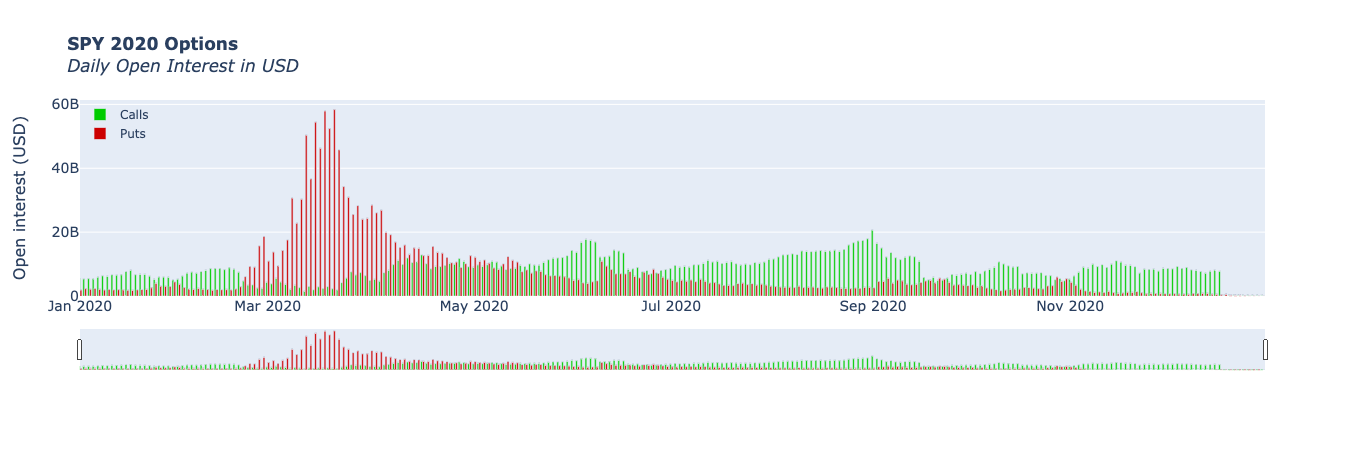

In [21]:
# create list of dates 
call_open_interest_by_day['quotedate'].dt.date
quotedate_list = call_open_interest_by_day['quotedate'].to_list()

# convert openinterest_$value into lists for calls and puts
call_open_interest_list = call_open_interest_by_day['openinterest_$value'].tolist()
put_open_interest_list = put_open_interest_by_day['openinterest_$value'].tolist()

# create volume chart by day
chart_open_interest_by_day = go.Figure()
chart_open_interest_by_day.add_trace(go.Bar(name='Calls',
                                     x=quotedate_list, 
                                     y=call_open_interest_list,
                                     marker_color='rgb(0,204,0)',
                                     text= call_open_interest_list, 
                                     texttemplate='%{text:.3s}', 
                                     textposition='outside'
                                    )
                                    )
chart_open_interest_by_day.add_trace(go.Bar(name='Puts',
                                     x=quotedate_list, 
                                     y=put_open_interest_list,
                                     marker_color='rgb(204,0,0)',
                                     text= put_open_interest_list, 
                                     texttemplate='%{text:.3s}', 
                                     textposition='outside')
                                    )
chart_open_interest_by_day.update_xaxes(rangeslider_visible=True,
                                 rangebreaks=[
                                     dict(bounds=["sat", "mon"]),
                                     dict(values=["2020-01-01",
                                                  "2020-01-20", 
                                                  "2020-02-17",
                                                  "2020-04-10",
                                                  "2020-05-25",
                                                  "2020-07-03", 
                                                  "2020-09-07", 
                                                  "2020-11-26", 
                                                  "2020-12-25"])]
                                       )
chart_open_interest_by_day.update_layout(title=f'<b>SPY 2020 Options</b><br><i>Daily Open Interest in USD</i>',
                                         xaxis_tickfont_size=14,
                                         yaxis=dict(
                                             title='Open interest (USD)',
                                             titlefont_size=16,
                                             tickfont_size=14,),
                                         legend=dict(
                                             x=0,
                                             y=1.0,
                                             bgcolor='rgba(255, 255, 255, 0)',
                                             bordercolor='rgba(255, 255, 255, 0)')
                                        )

# --VOLUME--
## Volume - Calls

In [22]:
# calculate options volume by day and groupby date and type
option_volume_by_day = df_stocks_and_options.groupby(['quotedate','type'])[['volume']].sum().reset_index()

# create call volumes df
call_volume_by_day = option_volume_by_day.loc[option_volume_by_day['type'] == 'call']
call_volume_by_day.reset_index(drop=True, inplace=True)
call_volume_by_day.head()

quotedate  type   volume
0 2020-01-02  call  1058845
1 2020-01-03  call  1234638
2 2020-01-06  call   945678
3 2020-01-07  call   870324
4 2020-01-08  call  1417889

## Volume - Puts

In [23]:
# create call volumes df
put_volume_by_day = option_volume_by_day.loc[option_volume_by_day['type'] == 'put']
put_volume_by_day.reset_index(drop=True, inplace=True)
put_volume_by_day.head()

quotedate type   volume
0 2020-01-02  put  1407619
1 2020-01-03  put  1937446
2 2020-01-06  put  1409353
3 2020-01-07  put   946351
4 2020-01-08  put  1647037

## Volume Bar Graph - Calls v. Puts

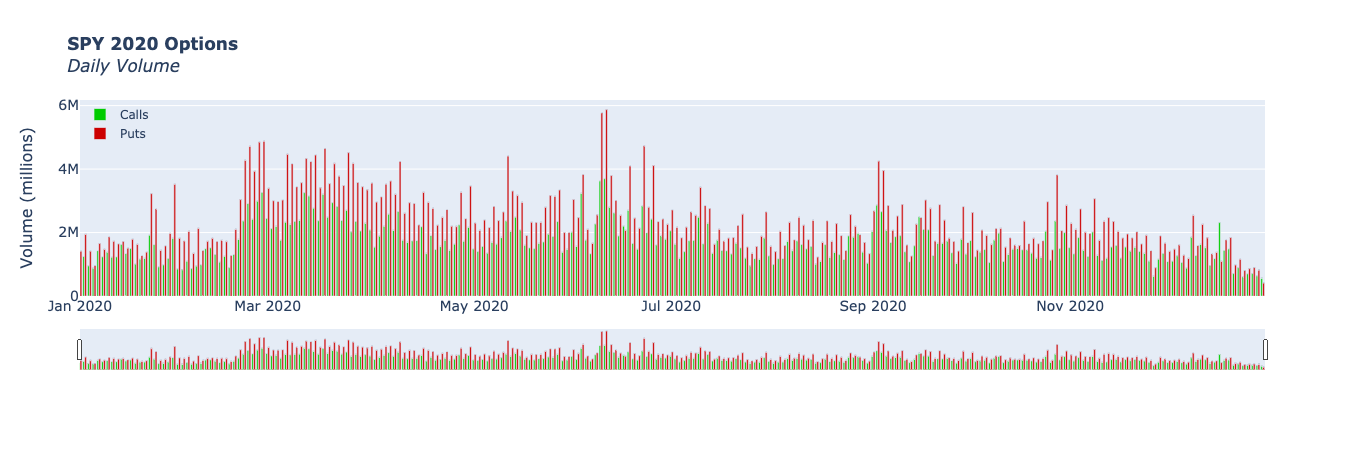

In [24]:
# create list of dates 
call_volume_by_day['quotedate'].dt.date
quotedate_list = call_volume_by_day['quotedate'].to_list()

# convert volume into lists for calls and puts
call_volume_list = call_volume_by_day['volume'].tolist()
put_volume_list = put_volume_by_day['volume'].tolist()

# create volume chart by day
chart_volume_by_day = go.Figure()
chart_volume_by_day.add_trace(go.Bar(name='Calls',
                                     x=quotedate_list, 
                                     y=call_volume_list,
                                     marker_color='rgb(0,204,0)',
                                     text= call_volume_list, 
                                     texttemplate='%{text:.3s}', 
                                     textposition='outside'
                                    )
                             )
chart_volume_by_day.add_trace(go.Bar(name='Puts',
                                     x=quotedate_list, 
                                     y=put_volume_list,
                                     marker_color='rgb(204,0,0)',
                                     text= put_volume_list, 
                                     texttemplate='%{text:.3s}', 
                                     textposition='outside')
                             )
chart_volume_by_day.update_xaxes(rangeslider_visible=True,
                                 rangebreaks=[
                                     dict(bounds=["sat", "mon"]),
                                     dict(values=["2020-01-01",
                                                  "2020-01-20", 
                                                  "2020-02-17",
                                                  "2020-04-10",
                                                  "2020-05-25",
                                                  "2020-07-03", 
                                                  "2020-09-07", 
                                                  "2020-11-26", 
                                                  "2020-12-25"])]
                                )
chart_volume_by_day.update_layout(title=f'<b>SPY 2020 Options</b><br><i>Daily Volume</i>',
                                  xaxis_tickfont_size=14,
                                  yaxis=dict(
                                      title='Volume (millions)',
                                      titlefont_size=16,
                                      tickfont_size=14,),
                                  legend=dict(
                                      x=0,
                                      y=1.0,
                                      bgcolor='rgba(255, 255, 255, 0)',
                                      bordercolor='rgba(255, 255, 255, 0)')
                                 )

# --CALL OPTIONS--
## Closing Prices - Top 3 Call Options (open interest)

In [25]:
# sort stocks and options data by open interest in descending order
sorted_df_stocks_and_options = df_stocks_and_options.sort_values(by='openinterest_$value', ascending=False)

# create new df to create call options df
df_call_only = sorted_df_stocks_and_options.loc[sorted_df_stocks_and_options['type'] == 'call']
df_call_only.reset_index(inplace=True)

# group puts by expiration date and sum open_interest_$value
df_call_by_exp_date = df_call_only.groupby(['expiration_date','strike','type'])[['openinterest_$value']].sum()
df_call_by_exp_date = df_call_by_exp_date.sort_values(by='openinterest_$value', ascending=False).reset_index()
df_call_by_exp_date.head(3)

expiration_date  strike  type  openinterest_$value
0      2020-12-18     315  call         3.305591e+10
1      2020-12-18     290  call         3.093919e+10
2      2020-12-18     310  call         3.035349e+10

## Closing Prices - 1st Call (open interest)

/opt/anaconda3/envs/pyvizenv/lib/python3.7/site-packages/pandas/core/frame.py:4025: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



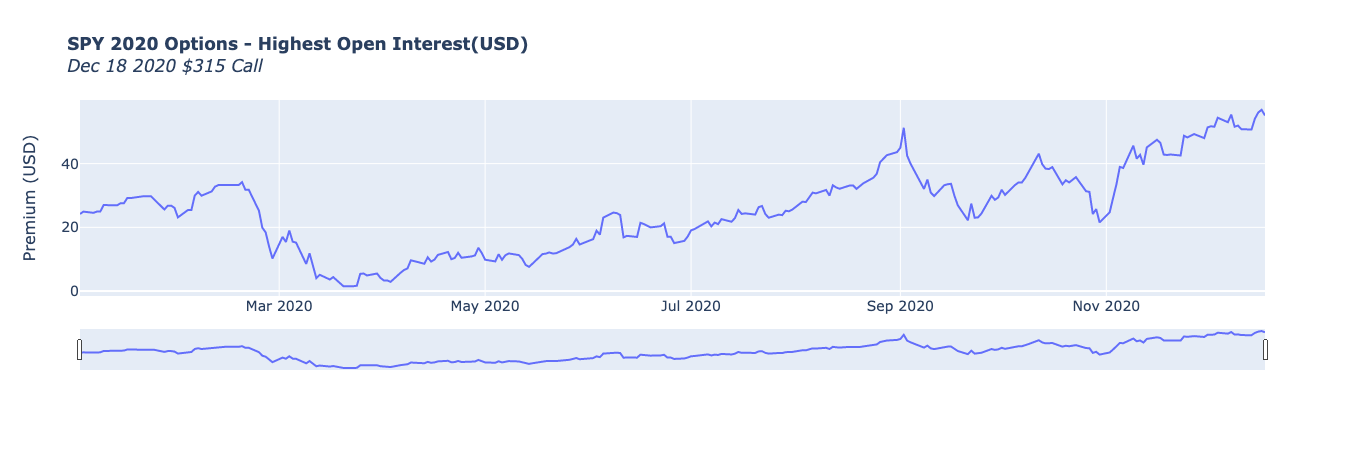

In [26]:
# create df for put option with 1st largest openinterest_$value
df_first_open_interest_call = df_call_only.loc[df_call_only['expiration_date'] == '2020-12-18']
df_first_open_interest_call = df_first_open_interest_call.loc[df_call_only['strike'] == 315.0]
df_first_open_interest_call = df_first_open_interest_call.sort_values('quotedate').reset_index(drop=True)

# slice data for closing prices of first option
first_open_interest_call_price = df_first_open_interest_call[['quotedate','last']]

# rename 'last' column to 'option_close' and set quotedate as index
first_open_interest_call_price.rename(columns = {'last':'option_close'}, inplace = True)
# first_open_interest_call_price.set_index(keys = "quotedate" , inplace = True)

# create list of dates 
first_open_interest_call_price['quotedate'].dt.date
first_call_quotedate_list = first_open_interest_call_price['quotedate'].to_list()

# convert closing price of first call into list
first_call_price_list = first_open_interest_call_price['option_close'].to_list()

# plot closing prices line chart
chart_first_open_interest_call = go.Figure()
chart_first_open_interest_call.add_trace(go.Scatter(x= first_call_quotedate_list,
                                                   y= first_call_price_list,
#                                                    mode='lines+markers',
                                                   name='Dec 18 2020 $315 Call')
                                       )
chart_first_open_interest_call.update_layout(title=f'<b>SPY 2020 Options - Highest Open Interest(USD)</b><br><i>Dec 18 2020 $315 Call</i>',
                                            xaxis_tickfont_size=14,
                                            yaxis=dict(
                                                title='Premium (USD)',
                                                titlefont_size=16,
                                                tickfont_size=14,),
                                            legend=dict(
                                                x=0,
                                                y=1.0,
                                                bgcolor='rgba(255, 255, 255, 0)',
                                                bordercolor='rgba(255, 255, 255, 0)')
                                           )
chart_first_open_interest_call.update_xaxes(rangeslider_visible=True)
chart_first_open_interest_call.show()

## Closing Prices - 2nd Call (open interest)

/opt/anaconda3/envs/pyvizenv/lib/python3.7/site-packages/pandas/core/frame.py:4025: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



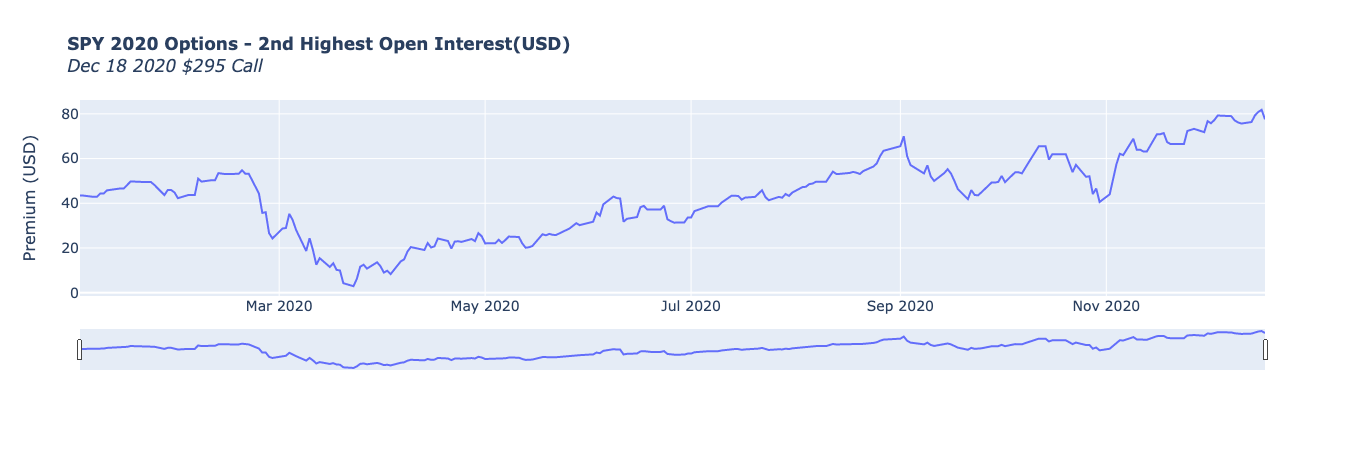

In [27]:
# create df for put option with 1st largest openinterest_$value
df_second_open_interest_call = df_call_only.loc[df_call_only['expiration_date'] == '2020-12-18']
df_second_open_interest_call = df_second_open_interest_call.loc[df_call_only['strike'] == 290.0]
df_second_open_interest_call = df_second_open_interest_call.sort_values('quotedate').reset_index(drop=True)

# slice data for closing prices of first option
second_open_interest_call_price = df_second_open_interest_call[['quotedate','last']]

# rename 'last' column to 'option_close' and set quotedate as index
second_open_interest_call_price.rename(columns = {'last':'option_close'}, inplace = True)
# first_open_interest_call_price.set_index(keys = "quotedate" , inplace = True)

# create list of dates 
second_open_interest_call_price['quotedate'].dt.date
second_call_quotedate_list = second_open_interest_call_price['quotedate'].to_list()

# convert closing price of first put into list
second_call_price_list = second_open_interest_call_price['option_close'].to_list()

# plot closing prices line chart
chart_second_open_interest_call = go.Figure()
chart_second_open_interest_call.add_trace(go.Scatter(x= second_call_quotedate_list,
                                                   y= second_call_price_list,
#                                                    mode='lines+markers',
                                                   name='Dec 18 2020 $295 Call')
                                       )
chart_second_open_interest_call.update_layout(title=f'<b>SPY 2020 Options - 2nd Highest Open Interest(USD)</b><br><i>Dec 18 2020 $295 Call</i>',
                                            xaxis_tickfont_size=14,
                                            yaxis=dict(
                                                title='Premium (USD)',
                                                titlefont_size=16,
                                                tickfont_size=14,),
                                            legend=dict(
                                                x=0,
                                                y=1.0,
                                                bgcolor='rgba(255, 255, 255, 0)',
                                                bordercolor='rgba(255, 255, 255, 0)')
                                           )
chart_second_open_interest_call.update_xaxes(rangeslider_visible=True)
chart_second_open_interest_call.show()

## Closing Prices - 3rd Call (open interest)

/opt/anaconda3/envs/pyvizenv/lib/python3.7/site-packages/pandas/core/frame.py:4025: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



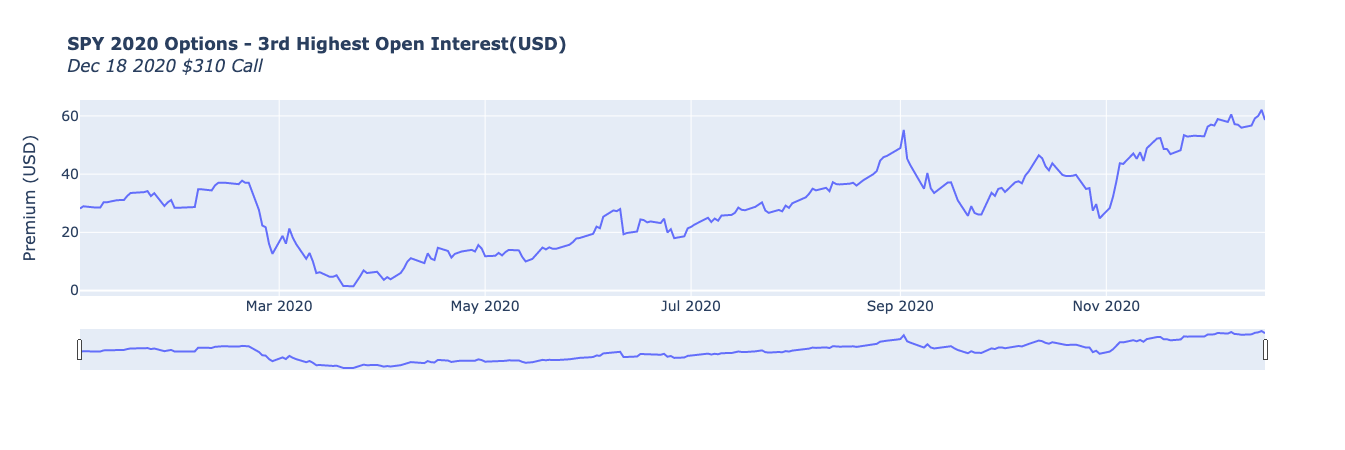

In [28]:
# create df for put option with 1st largest openinterest_$value
df_third_open_interest_call = df_call_only.loc[df_call_only['expiration_date'] == '2020-12-18']
df_third_open_interest_call = df_third_open_interest_call.loc[df_call_only['strike'] == 310.0]
df_third_open_interest_call = df_third_open_interest_call.sort_values('quotedate').reset_index(drop=True)

# slice data for closing prices of first option
third_open_interest_call_price = df_third_open_interest_call[['quotedate','last']]

# rename 'last' column to 'option_close' and set quotedate as index
third_open_interest_call_price.rename(columns = {'last':'option_close'}, inplace = True)
# first_open_interest_call_price.set_index(keys = "quotedate" , inplace = True)

# create list of dates 
third_open_interest_call_price['quotedate'].dt.date
third_call_quotedate_list = third_open_interest_call_price['quotedate'].to_list()

# convert closing price of first put into list
third_call_price_list = third_open_interest_call_price['option_close'].to_list()

# plot closing prices line chart
chart_third_open_interest_call = go.Figure()
chart_third_open_interest_call.add_trace(go.Scatter(x= third_call_quotedate_list,
                                                   y= third_call_price_list,
#                                                    mode='lines+markers',
                                                   name='Dec 18 2020 $310 Call')
                                       )
chart_third_open_interest_call.update_layout(title=f'<b>SPY 2020 Options - 3rd Highest Open Interest(USD)</b><br><i>Dec 18 2020 $310 Call</i>',
                                            xaxis_tickfont_size=14,
                                            yaxis=dict(
                                                title='Premium (USD)',
                                                titlefont_size=16,
                                                tickfont_size=14,),
                                            legend=dict(
                                                x=0,
                                                y=1.0,
                                                bgcolor='rgba(255, 255, 255, 0)',
                                                bordercolor='rgba(255, 255, 255, 0)')
                                           )
chart_third_open_interest_call.update_xaxes(rangeslider_visible=True)
chart_third_open_interest_call.show()

# --PUT OPTIONS--
## Closing Prices - Top 3 Put Options (open interest)

In [29]:
# slice data to create put options df
df_put_only = sorted_df_stocks_and_options.loc[sorted_df_stocks_and_options['type'] == 'put']
df_put_only.reset_index(inplace=True)

# group puts by expiration date
df_put_by_exp_date = df_put_only.groupby(['expiration_date','strike','type'])[['openinterest_$value']].sum()
df_put_by_exp_date = df_put_by_exp_date.sort_values(by='openinterest_$value', ascending=False).reset_index()
df_put_by_exp_date.head(3)

expiration_date  strike type  openinterest_$value
0      2020-09-18     295  put         3.220908e+10
1      2020-10-16     260  put         2.397588e+10
2      2020-06-19     280  put         2.086703e+10

## Closing Prices - 1st Put (open interest)

/opt/anaconda3/envs/pyvizenv/lib/python3.7/site-packages/pandas/core/frame.py:4025: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/opt/anaconda3/envs/pyvizenv/lib/python3.7/site-packages/pandas/core/frame.py:4025: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



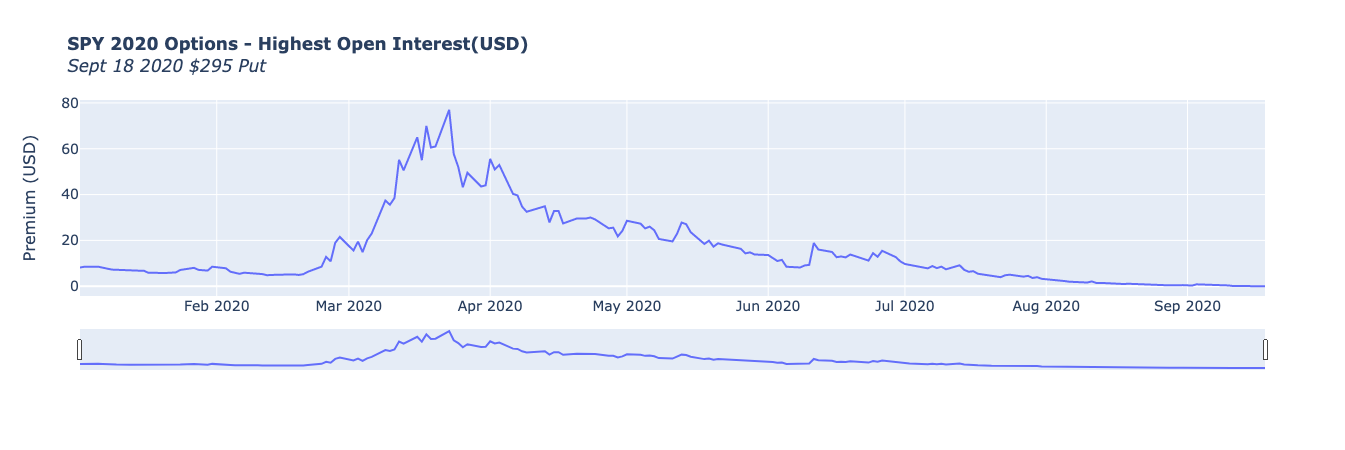

In [30]:
# create df for put option with 1st largest openinterest_$value
df_first_open_interest_put = df_put_only.loc[df_put_only['expiration_date'] == '2020-09-18']
df_first_open_interest_put = df_first_open_interest_put.loc[df_put_only['strike'] == 295.0]
df_first_open_interest_put = df_first_open_interest_put.sort_values('quotedate').reset_index(drop=True)

# create new df for closing prices of first option
first_open_interest_put_price = df_first_open_interest_put[['quotedate','last']]

# rename 'last' column to 'option_close' and set quotedate as index
first_open_interest_put_price.rename(columns = {'last':'option_close'}, inplace = True)
# first_open_interest_put_price.set_index(keys = "quotedate" , inplace = True)

# create df for put option with 1st largest openinterest_$value
df_first_open_interest_put = df_put_only.loc[df_put_only['expiration_date'] == '2020-09-18']
df_first_open_interest_put = df_first_open_interest_put.loc[df_put_only['strike'] == 295.0]
df_first_open_interest_put = df_first_open_interest_put.sort_values('quotedate').reset_index(drop=True)

# create new df for closing prices of first option
first_open_interest_put_price = df_first_open_interest_put[['quotedate','last']]

# rename 'last' column to 'option_close' and set quotedate as index
first_open_interest_put_price.rename(columns = {'last':'option_close'}, inplace = True)
# first_open_interest_put_price.set_index(keys = "quotedate" , inplace = True)

# create list of dates 
first_open_interest_put_price['quotedate'].dt.date
first_put_quotedate_list = first_open_interest_put_price['quotedate'].to_list()

# convert closing price of first put into list
first_put_price_list = first_open_interest_put_price['option_close'].to_list()

# plot closing prices line chart
chart_first_open_interest_put = go.Figure()
chart_first_open_interest_put.add_trace(go.Scatter(x= first_put_quotedate_list,
                                                   y= first_put_price_list,
#                                                    mode='lines+markers',
                                                   name='Sept 18 2020 $295 Put')
                                      )
chart_first_open_interest_put.update_layout(title='<b>SPY 2020 Options - Highest Open Interest(USD)</b><br><i>Sept 18 2020 $295 Put</i>',
                                            xaxis_tickfont_size=14,
                                            yaxis=dict(
                                                title='Premium (USD)',
                                                titlefont_size=16,
                                                tickfont_size=14,),
                                            legend=dict(
                                                x=0,
                                                y=1.0,
                                                bgcolor='rgba(255, 255, 255, 0)',
                                                bordercolor='rgba(255, 255, 255, 0)')
                                           )
chart_first_open_interest_put.update_xaxes(rangeslider_visible=True)
chart_first_open_interest_put.show()

## Closing Prices - 2nd Put (open interest)

/opt/anaconda3/envs/pyvizenv/lib/python3.7/site-packages/pandas/core/frame.py:4025: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



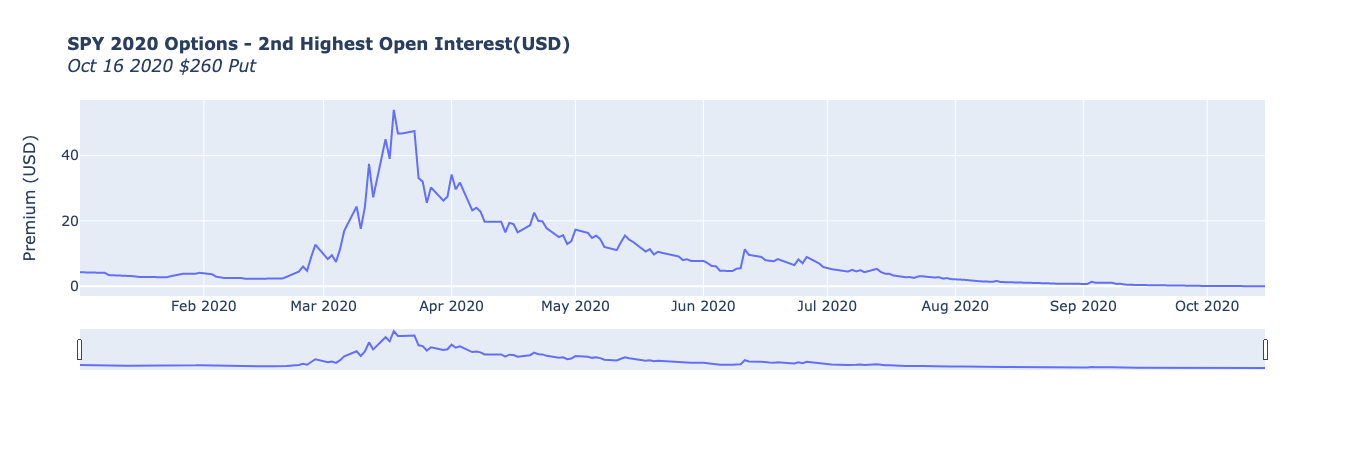

In [31]:
# create df for put option with 1st largest openinterest_$value
df_second_open_interest_put = df_put_only.loc[df_put_only['expiration_date'] == '2020-10-16']
df_second_open_interest_put = df_second_open_interest_put.loc[df_put_only['strike'] == 260.0]
df_second_open_interest_put = df_second_open_interest_put.sort_values('quotedate').reset_index(drop=True)

# create new df for closing prices of first option
second_open_interest_put_price = df_second_open_interest_put[['quotedate','last']]

# rename 'last' column to 'option_close' and set quotedate as index
second_open_interest_put_price.rename(columns = {'last':'option_close'}, inplace = True)
# first_open_interest_put_price.set_index(keys = "quotedate" , inplace = True)

# create list of dates 
second_open_interest_put_price['quotedate'].dt.date
second_put_quotedate_list = second_open_interest_put_price['quotedate'].to_list()

# convert closing price of first put into list
second_put_price_list = second_open_interest_put_price['option_close'].to_list()

# plot closing prices line chart
chart_second_open_interest_put = go.Figure()
chart_second_open_interest_put.add_trace(go.Scatter(x= second_put_quotedate_list,
                                                   y= second_put_price_list,
#                                                    mode='lines+markers',
                                                   name='Oct 16 2020 $260 Put')
                                       )
chart_second_open_interest_put.update_layout(title='<b>SPY 2020 Options - 2nd Highest Open Interest(USD)</b><br><i>Oct 16 2020 $260 Put</i>',
                                            xaxis_tickfont_size=14,
                                            yaxis=dict(
                                                title='Premium (USD)',
                                                titlefont_size=16,
                                                tickfont_size=14,),
                                            legend=dict(
                                                x=0,
                                                y=1.0,
                                                bgcolor='rgba(255, 255, 255, 0)',
                                                bordercolor='rgba(255, 255, 255, 0)')
                                           )
chart_second_open_interest_put.update_xaxes(rangeslider_visible=True)
chart_second_open_interest_put.show()

## Closing Prices - 3rd Put (open interest)

/opt/anaconda3/envs/pyvizenv/lib/python3.7/site-packages/pandas/core/frame.py:4025: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



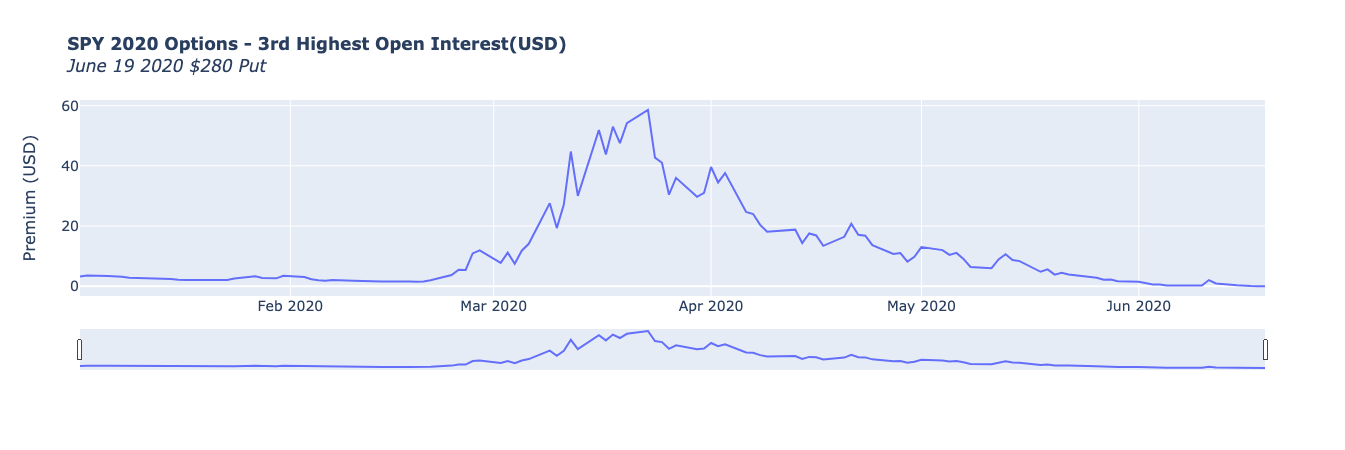

In [32]:
# create df for put option with 1st largest openinterest_$value
df_third_open_interest_put = df_put_only.loc[df_put_only['expiration_date'] == '2020-06-19']
df_third_open_interest_put = df_third_open_interest_put.loc[df_put_only['strike'] == 280.0]
df_third_open_interest_put = df_third_open_interest_put.sort_values('quotedate').reset_index(drop=True)

# create new df for closing prices of first option
third_open_interest_put_price = df_third_open_interest_put[['quotedate','last']]

# rename 'last' column to 'option_close' and set quotedate as index
third_open_interest_put_price.rename(columns = {'last':'option_close'}, inplace = True)
# first_open_interest_put_price.set_index(keys = "quotedate" , inplace = True)

# create list of dates 
third_open_interest_put_price['quotedate'].dt.date
third_put_quotedate_list = third_open_interest_put_price['quotedate'].to_list()

# convert closing price of first put into list
third_put_price_list = third_open_interest_put_price['option_close'].to_list()

# plot closing prices line chart
chart_third_open_interest_put = go.Figure()
chart_third_open_interest_put.add_trace(go.Scatter(x= third_put_quotedate_list,
                                                   y= third_put_price_list,
#                                                    mode='lines+markers',
                                                   name='June 19 2020 $280 Put')
                                       )
chart_third_open_interest_put.update_layout(title='<b>SPY 2020 Options - 3rd Highest Open Interest(USD)</b><br><i>June 19 2020 $280 Put</i>',
                                            xaxis_tickfont_size=14,
                                            yaxis=dict(
                                                title='Premium (USD)',
                                                titlefont_size=16,
                                                tickfont_size=14,),
                                            legend=dict(
                                                x=0,
                                                y=1.0,
                                                bgcolor='rgba(255, 255, 255, 0)',
                                                bordercolor='rgba(255, 255, 255, 0)')
                                           )
chart_third_open_interest_put.update_xaxes(rangeslider_visible=True)
chart_third_open_interest_put.show()

## Open Interest - Correlation (Calls)

In [33]:
call_by_exp_date = df_call_by_exp_date.groupby(['expiration_date','type'])[['openinterest_$value']].sum().reset_index()
call_by_exp_date.set_index(pd.to_datetime(call_by_exp_date['expiration_date'], infer_datetime_format=True), inplace=True)
call_by_exp_date.drop(columns=['expiration_date', 'type'], inplace=True)
call_by_exp_date.head()

openinterest_$value
expiration_date                     
2020-01-03                79270994.0
2020-01-06                24921066.0
2020-01-08                61845684.0
2020-01-10               337469073.0
2020-01-13               111094513.0

## Open Interest - Correlation (Puts)

In [34]:
put_by_exp_date = df_put_by_exp_date.groupby(['expiration_date','type'])[['openinterest_$value']].sum().reset_index()
put_by_exp_date.set_index(pd.to_datetime(put_by_exp_date['expiration_date'], infer_datetime_format=True), inplace=True)
put_by_exp_date.drop(columns=['expiration_date', 'type'], inplace=True)
put_by_exp_date.head()

openinterest_$value
expiration_date                     
2020-01-03                11595212.0
2020-01-06                 6446086.0
2020-01-08                17528731.0
2020-01-10                74804762.0
2020-01-13                17771654.0

In [35]:
# call option volume daily change
call_open_interest_change = call_by_exp_date.pct_change()
# call_open_interest_change = call_open_interest_change.rename(columns={"openinterest_$value": "call open interest"})
call_open_interest_change.head()

openinterest_$value
expiration_date                     
2020-01-03                       NaN
2020-01-06                 -0.685622
2020-01-08                  1.481663
2020-01-10                  4.456631
2020-01-13                 -0.670801

In [36]:
# put option volume daily change
put_open_interest_change = put_by_exp_date.pct_change()
put_open_interest_change = put_open_interest_change.rename(columns={"openinterest_$value": "put open interest"})
put_open_interest_change.head()

put open interest
expiration_date                   
2020-01-03                     NaN
2020-01-06               -0.444073
2020-01-08                1.719283
2020-01-10                3.267551
2020-01-13               -0.762426

In [37]:
# spy close daily change
spy_daily_change = spy_close_prices.pct_change()

spy_daily_change.head()

spy_close
Date                 
2020-01-02        NaN
2020-01-03  -0.007572
2020-01-06   0.003815
2020-01-07  -0.002812
2020-01-08   0.005330

In [38]:
spy_change_and_option_interest = pd.concat([call_open_interest_change, put_open_interest_change, spy_daily_change], axis="columns", join="inner")
spy_change_and_option_interest.head()

openinterest_$value  put open interest  spy_close
2020-01-03                  NaN                NaN  -0.007572
2020-01-06            -0.685622          -0.444073   0.003815
2020-01-08             1.481663           1.719283   0.005330
2020-01-10             4.456631           3.267551  -0.002878
2020-01-13            -0.670801          -0.762426   0.006877

<AxesSubplot:>

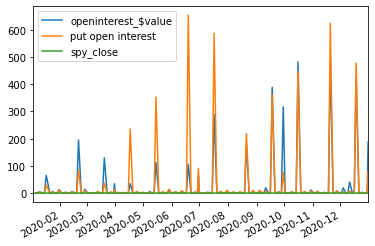

In [39]:
spy_change_and_option_interest.plot()

In [40]:
#calculate corralation
stock_option_corr = spy_change_and_option_interest.corr()
stock_option_corr

openinterest_$value  put open interest  spy_close
openinterest_$value             1.000000           0.823914  -0.068494
put open interest               0.823914           1.000000  -0.039504
spy_close                      -0.068494          -0.039504   1.000000

<AxesSubplot:>

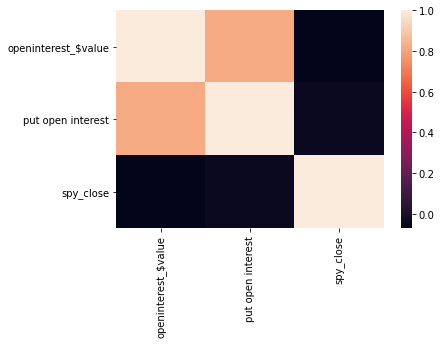

In [41]:
# spy and option corralation heatmap
sns.heatmap(stock_option_corr)

In [42]:
# get call volumes df
call_volume = option_volume_by_day.loc[option_volume_by_day['type'] == 'call']
call_volume = call_volume.rename(columns={"volume": "call volume"})
call_volume = call_volume.drop(columns = 'type')
call_volume.set_index(keys='quotedate', inplace=True)
call_volume.head()

call volume
quotedate              
2020-01-02      1058845
2020-01-03      1234638
2020-01-06       945678
2020-01-07       870324
2020-01-08      1417889

In [43]:
# get put volumes df
put_volume = option_volume_by_day.loc[option_volume_by_day['type'] == 'put']
put_volume = put_volume.rename(columns={"volume": "put volume"})
put_volume = put_volume.drop(columns = 'type')
put_volume.set_index(keys='quotedate', inplace=True)
put_volume.head()

put volume
quotedate             
2020-01-02     1407619
2020-01-03     1937446
2020-01-06     1409353
2020-01-07      946351
2020-01-08     1647037

In [44]:
# sum option daily volume 
option_volume_sum = option_volume_by_day.groupby('quotedate').sum()
option_volume_sum = option_volume_sum.rename(columns={"volume": "total option volume"})
option_volume_sum.head()

total option volume
quotedate                      
2020-01-02              2466464
2020-01-03              3172084
2020-01-06              2355031
2020-01-07              1816675
2020-01-08              3064926

In [45]:
# options implied price by type
option_implied_price_by_type = z.groupby(['quotedate','type'])[['Options_Implied_Price']].mean().reset_index()
option_implied_price_by_type.set_index(pd.to_datetime(option_implied_price_by_type['quotedate'], infer_datetime_format=True), inplace=True)
# option_implied_price_by_type = option_implied_price_by_type.drop(columns = ['quotedate'])
option_implied_price_by_type.head()

quotedate  type  Options_Implied_Price
quotedate                                         
2020-01-02 2020-01-02  call             330.602000
2020-01-02 2020-01-02   put             317.543871
2020-01-03 2020-01-03  call             329.094722
2020-01-03 2020-01-03   put             315.593784
2020-01-06 2020-01-06  call             330.503636

In [46]:
# get put options implied price 
put_implied_price = option_implied_price_by_type.loc[option_implied_price_by_type['type'] == 'put']
put_implied_price = put_implied_price.rename(columns={"Options_Implied_Price": "put price"})
put_implied_price = put_implied_price.drop(columns = ['type', 'quotedate'])
put_implied_price.head()

put price
quotedate             
2020-01-02  317.543871
2020-01-03  315.593784
2020-01-06  316.291515
2020-01-07  315.436176
2020-01-08  317.284848

In [47]:
# get buy options implied price 
call_implied_price = option_implied_price_by_type.loc[option_implied_price_by_type['type'] == 'call']
call_implied_price = call_implied_price.rename(columns={"Options_Implied_Price": "call price"})
call_implied_price = call_implied_price.drop(columns = ['type', 'quotedate'])
call_implied_price.head()

call price
quotedate             
2020-01-02  330.602000
2020-01-03  329.094722
2020-01-06  330.503636
2020-01-07  329.668824
2020-01-08  331.069375

In [48]:
# call option volume daily change
call_implied_price_change = call_implied_price.pct_change()
call_implied_price_change = call_implied_price_change.rename(columns={"call price": "call change"})
call_implied_price_change.head()

call change
quotedate              
2020-01-02          NaN
2020-01-03    -0.004559
2020-01-06     0.004281
2020-01-07    -0.002526
2020-01-08     0.004248

In [49]:
# put option volume daily change
put_implied_price_change = put_implied_price.pct_change()
put_implied_price_change = put_implied_price_change.rename(columns={"put price": "put change"})
put_implied_price_change.head()

put change
quotedate             
2020-01-02         NaN
2020-01-03   -0.006141
2020-01-06    0.002211
2020-01-07   -0.002704
2020-01-08    0.005861

In [50]:
# option volume daily change
option_volume_daily_change = option_volume_sum.pct_change()
option_volume_daily_change.columns = [ 'option volume daily change']
option_volume_daily_change.head()

option volume daily change
quotedate                             
2020-01-02                         NaN
2020-01-03                    0.286086
2020-01-06                   -0.257576
2020-01-07                   -0.228598
2020-01-08                    0.687107

In [51]:
#calculate spy daily returns
spy_daily_returns = spy_close_prices.pct_change()
spy_daily_returns.columns = [ 'daily_return']
spy_daily_returns.head()

daily_return
Date                    
2020-01-02           NaN
2020-01-03     -0.007572
2020-01-06      0.003815
2020-01-07     -0.002812
2020-01-08      0.005330

In [52]:
# concat option volume and spy daily return
option_sum_and_daily_return = pd.concat([option_volume_sum, 
                                         spy_daily_change, 
                                         call_volume, 
                                         put_volume, 
                                         call_implied_price, 
                                         put_implied_price, 
                                         call_implied_price_change, 
                                         put_implied_price_change], axis="columns", join="inner")
option_sum_and_daily_return.head()

total option volume  spy_close  call volume  put volume  \
2020-01-02              2466464        NaN      1058845     1407619   
2020-01-03              3172084  -0.007572      1234638     1937446   
2020-01-06              2355031   0.003815       945678     1409353   
2020-01-07              1816675  -0.002812       870324      946351   
2020-01-08              3064926   0.005330      1417889     1647037   

            call price   put price  call change  put change  
2020-01-02  330.602000  317.543871          NaN         NaN  
2020-01-03  329.094722  315.593784    -0.004559   -0.006141  
2020-01-06  330.503636  316.291515     0.004281    0.002211  
2020-01-07  329.668824  315.436176    -0.002526   -0.002704  
2020-01-08  331.069375  317.284848     0.004248    0.005861

In [53]:
#calculate corralation
stock_option_corr = option_sum_and_daily_return.corr()
stock_option_corr

total option volume  spy_close  call volume  put volume  \
total option volume             1.000000  -0.227142     0.966590    0.987641   
spy_close                      -0.227142   1.000000    -0.194118   -0.239854   
call volume                     0.966590  -0.194118     1.000000    0.914469   
put volume                      0.987641  -0.239854     0.914469    1.000000   
call price                     -0.622164   0.094033    -0.564754   -0.636868   
put price                      -0.651502   0.100161    -0.593500   -0.665605   
call change                    -0.216061   0.984326    -0.186113   -0.227258   
put change                     -0.240572   0.992217    -0.205080   -0.254351   

                     call price  put price  call change  put change  
total option volume   -0.622164  -0.651502    -0.216061   -0.240572  
spy_close              0.094033   0.100161     0.984326    0.992217  
call volume           -0.564754  -0.593500    -0.186113   -0.205080  
put volume            -0.636868  -0.665605    -0.227258   -0.254351  
call price             1.000000   0.996485     0.101977    0.088368  
put price              0.996485   1.000000     0.103392    0.097863  
call change            0.101977   0.103392     1.000000    0.968165  
put change             0.088368   0.097863     0.968165    1.000000

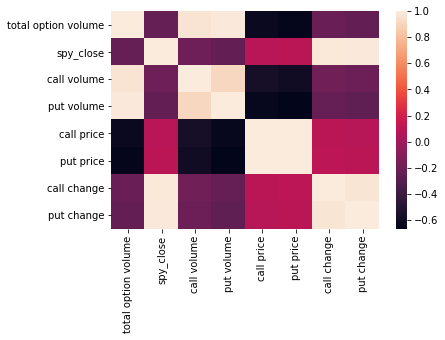

In [69]:
# spy and option corralation heatmap
correlations = sns.heatmap(stock_option_corr)

In [71]:
# # Create a Title for the Dashboard
title = '#Visualizing the Relationship Between Options and Stock Prices'

# # Create a tab layout for the dashboard
cover_page = pn.Column(title)

tab_1 = pn.Column(
     "## Review of 2020 Stock Price Performance",
    spy_candlestick_chart,
)

tab_2 = pn.Column(
     "## SPY Option Volume and Open Interest",
    chart_spy_close_prices,
    chart_open_interest_by_day,
    chart_volume_by_day,
)


row_of_call = pn.Row(chart_first_open_interest_call,chart_second_open_interest_call)
row_of_put = pn.Row(chart_first_open_interest_put,chart_second_open_interest_put)

tab_3 = pn.Column(
     "## Review of Most Active Options",
     row_of_call,
     row_of_put
)


tab_4 = pn.Column(
     "## Visualizing Predictive Power of Options",
    plot_1,
    plot_3,
)



dashboard = pn.Tabs(
     ("Cover Page",cover_page),
     ("Historical Prices",tab_1),
     ("Volume and Open Interest",tab_2),
     ("Most Traded Options",tab_3),
     ("Implied prices vs. Actual",tab_4),
 )

# # Serve the# dashboard
dashboard.servable()

Tabs
    [0] Column
        [0] Markdown(str)
    [1] Column
        [0] Markdown(str)
        [1] Plotly(Figure)
    [2] Column
        [0] Markdown(str)
        [1] Plotly(Figure)
        [2] Plotly(Figure)
        [3] Plotly(Figure)
    [3] Column
        [0] Markdown(str)
        [1] Row
            [0] Plotly(Figure)
            [1] Plotly(Figure)
        [2] Row
            [0] Plotly(Figure)
            [1] Plotly(Figure)
    [4] Column
        [0] Markdown(str)
        [1] HoloViews(NdOverlay)
        [2] HoloViews(Overlay)